# Overview
The notebook is used for preprocessing the UnityEyes data so we can create one giant hdf5 file for use training neural networks. The notebook was made on windows but should work as well on Linux with that version of UnityEyes (http://www.cl.cam.ac.uk/research/rainbow/projects/unityeyes/tutorial.html)

In [9]:
from skimage.io import imread
from glob import glob
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import h5py
import numpy as np
unityeyes_dir = os.path.relpath('C:\\Users\\Kevin Mader\\Downloads\\UnityEyes_Windows\\UnityEyes_Windows')

ImportError: No module named 'tqdm'

In [2]:
all_json_files = glob(os.path.join(unityeyes_dir, 'imgs', '*.json'))[:1000]

In [3]:
def read_gaze_json(in_path):
    with open(in_path,'r') as t:
        j_obj=json.load(t)
        j_obj['path']=in_path
        return j_obj
def read_gaze_jpeg(in_path):
    c_img = imread(in_path)
    sym_img = c_img[:, 64:(384+64)]
    return sym_img[64:(256+64):2,64:(256+64):2]

In [4]:
%%time
gaze_df = pd.DataFrame([read_gaze_json(a_path) for a_path in all_json_files])
gaze_df['image_path'] = gaze_df['path'].map(lambda x: '{}.jpg'.format(os.path.splitext(x)[0]))
# keep only the images which are present
gaze_df = gaze_df[gaze_df['image_path'].map(lambda x: os.path.exists(x))]

Wall time: 7.21 s


caruncle_2d           [(218.6133, 182.3714, 8.9393), (214.9875, 188....
eye_details           {'look_vec': '(0.2488, 0.4507, -0.8573, 0.0000...
eye_region_details    {'pca_shape_coeffs': ['0.002962368', '0.017582...
head_pose                                  (347.7884, 196.8153, 0.0000)
interior_margin_2d    [(226.7275, 194.7304, 8.9645), (221.4500, 203....
iris_2d               [(242.3773, 216.7518, 8.9346), (242.5291, 221....
lighting_details      {'ambient_intensity': '0.9269464', 'skybox_tex...
path                  ..\..\..\..\Downloads\UnityEyes_Windows\UnityE...
image_path            ..\..\..\..\Downloads\UnityEyes_Windows\UnityE...
Name: 728, dtype: object


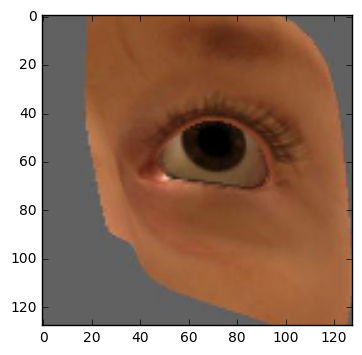

In [5]:
%matplotlib inline
for _, c_row in gaze_df.sample(1).iterrows():
    plt.imshow(read_gaze_jpeg(c_row['image_path']))
    print(c_row)

In [6]:
%%time
with h5py.File('gaze.h5', 'w') as t_file:
    img_group = t_file.create_group('image')
    look_ds = np.stack(gaze_df['eye_details'].map(lambda x: eval(x['look_vec'])).values,0)
    t_file.create_dataset('look_vec', data=look_ds, compression='gzip')
    dt = h5py.special_dtype(vlen=str)
    t_file.create_dataset('path', data=gaze_df['image_path'].values, dtype=dt, compression='gzip')
    for c_idx, c_row in gaze_df.iterrows():
        img_group.create_dataset(c_row['image_path'], data=read_gaze_jpeg(c_row['image_path']), compression='gzip')
        

Wall time: 18.8 s


In [7]:
# check the file quickly
with h5py.File('gaze.h5') as t_file:
    print(list(t_file.keys()))
    #print(list(t_file['image']))

['image', 'look_vec', 'path']
